<a href="https://colab.research.google.com/github/kdj0712/study_data_analytics/blob/main/docs/quests/CDAs/CDA_mixed_normal_heteroscedasticity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (범주형 / 연속형) 등분산 케이스 예제

#### 사전작업

In [ ]:
# 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용
import matplotlib.font_manager as fm
# 설치된 폰트 중 'NanumGothic' 찾기
for font in fm.fontManager.ttflist:
    if 'NanumGothic' in font.name:
        plt.rcParams['font.family'] = font.name
        break
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [3]:
df_store = pd.read_csv("/content/drive/MyDrive/data_analytics/CSV파일/fruitstore_saleshistory.csv")
df_store[:2]

,공급일자,요일,공급월,공급주차,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,구매수량,주소-구,주소-동,성별,연령,연령대,구매금액,구매매장,반품_원거래일자,구매시각
0,2018-01-02,화,1,1,272369856,정상회원,과실,과일,사과,사과/유(1.5kg),1.0,수지구,풍덕천동,여,45.0,40대,22207,매장C,NaN,10:04
1,2018-01-02,화,1,1,1506656256,정상회원,채소,버섯,느타리버섯,느타리버섯(300g),1.0,수지구,풍덕천동,여,36.0,30대이하,4977,매장C,NaN,10:05


## 2. 회원의 연령대(범주형)에 따라 구매 빈도(연속형)의 분산이 동일한지 검증합니다.
   - 연령대별 구매 빈도의 등분산성을 검증하기 위해 Levene의 등분산 검정을 사용합니다.


### 분석내용 : 회원의 연령대에 따라 구매 빈도의 분산이 동일한가?
- 귀무 가설 : 회원의 연령대에 따라 구매 빈도의 분산이 동일하다.
- 대립 가설 : 회원의 연령대에 따라 구매 빈도의 분산이 동일하지 않다

## 회원의 연령대의 구분을 세분화하고, 결측치를 제거하고, 구매 빈도에 대한 기준을 정립

### 1. 기존 데이터 확인

In [4]:
# 구매고객의 연령이 기재되지 않은 고객의 정보 제거(확인 결과 해당 고객은 1명)
df_store = df_store.dropna(subset=['연령'])

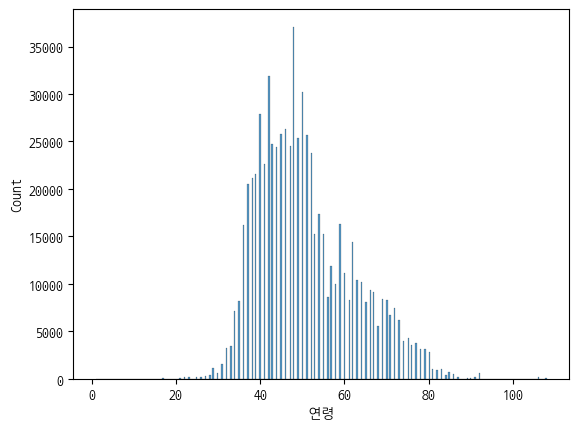

In [5]:
# 연령을 기준으로 한 히스토그램을 통해 구매 건수를 파악
sns.histplot(data=df_store, x='연령')
plt.show()

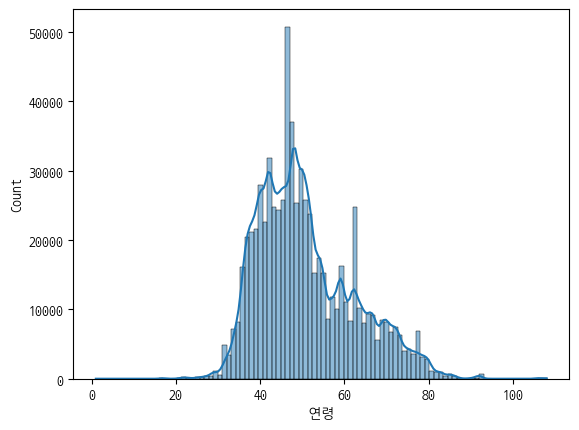

In [6]:
df_store_age = df_store['연령'].copy()
sns.histplot(data=df_store_age, bins=100, kde=True)
plt.show()

In [7]:
# stats.anderson을 사용한 정규 분포 검정을 통해, 현재의 측정치로는 정규분포에 부합하지 않는 다는 사실을 확인
result = stats.anderson(df_store_age)
print('Test Statistic: %.3f' % result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('%.1f%% 수준에서 데이터는 정규 분포를 따름 (검정 통계량 %.3f < 임계값 %.3f)' % (sl, result.statistic, cv))
    else:
        print('%.1f%% 수준에서 데이터는 정규 분포를 따르지 않음 (검정 통계량 %.3f >= 임계값 %.3f)' % (sl, result.statistic, cv))

Test Statistic: 10342.369
15.0% 수준에서 데이터는 정규 분포를 따르지 않음 (검정 통계량 10342.369 >= 임계값 0.576)
10.0% 수준에서 데이터는 정규 분포를 따르지 않음 (검정 통계량 10342.369 >= 임계값 0.656)
5.0% 수준에서 데이터는 정규 분포를 따르지 않음 (검정 통계량 10342.369 >= 임계값 0.787)
2.5% 수준에서 데이터는 정규 분포를 따르지 않음 (검정 통계량 10342.369 >= 임계값 0.918)
1.0% 수준에서 데이터는 정규 분포를 따르지 않음 (검정 통계량 10342.369 >= 임계값 1.092)


### 2. 연령대의 기준 세분화

In [8]:
# 연령대를 조금 더 다양한 묶음을 만들어 새로운 데이터 프레임 생성
df_store_group = df_store
bins = [0, 20, 30, 40, 50, 60, 70, 80, np.inf]
labels = ["20대 이하","20대", "30대", "40대", "50대", "60대", "70대", "80대 이상"]
df_store_group['age_group'] = pd.cut(df_store_group['연령'], bins=bins, labels=labels, right=False, include_lowest=True)

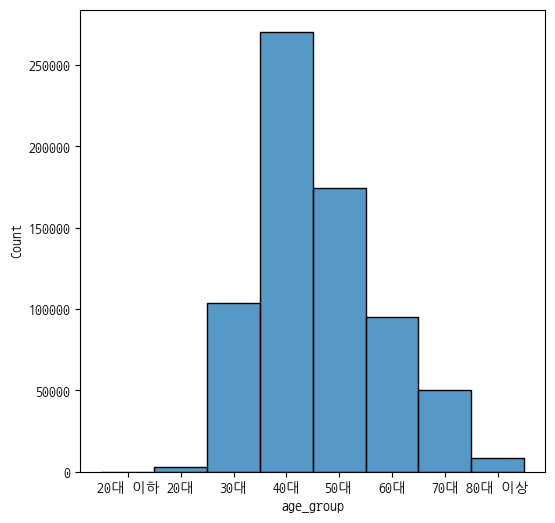

In [9]:
# 재분배한 연령대를 기준으로 한 히스토그램을 통해 구매 건수를 파악
plt.figure(figsize=(6,6))
sns.histplot(data=df_store_group, x='age_group')
plt.show()

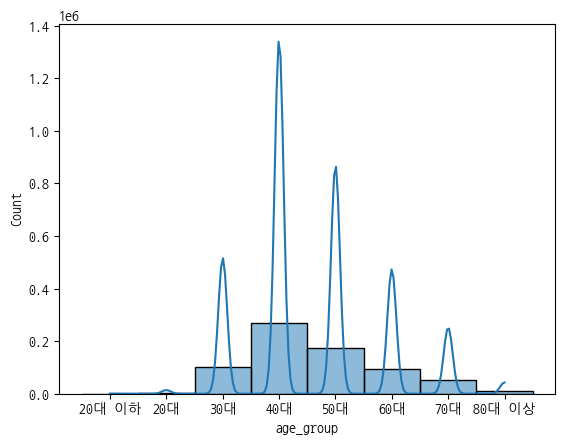

In [10]:
# 각 X 축 별 보유한 값이 많은 관계로 개별 값마다 높은 봉우리 형태의 그래프가 형성
sns.histplot(data=df_store_group, x='age_group', bins=1000, kde=True)
plt.show()

In [11]:
df_store_group[:2]

,공급일자,요일,공급월,공급주차,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,...,주소-구,주소-동,성별,연령,연령대,구매금액,구매매장,반품_원거래일자,구매시각,age_group
0,2018-01-02,화,1,1,272369856,정상회원,과실,과일,사과,사과/유(1.5kg),...,수지구,풍덕천동,여,45.0,40대,22207,매장C,NaN,10:04,40대
1,2018-01-02,화,1,1,1506656256,정상회원,채소,버섯,느타리버섯,느타리버섯(300g),...,수지구,풍덕천동,여,36.0,30대이하,4977,매장C,NaN,10:05,30대


### 3. 세분화 작업을 한 새로운 연령대를 기준으로, 구매건수의 통합과 구매금액의 통합을 한 새로운 데이터 프레임 생성

- 구매 건수 확인을 위해 공급일자와 구매시각을 통합해 새로운 시간 기준을 생성

In [12]:
df_store_group.loc[:,'Date']= pd.to_datetime(df_store_group['공급일자'],format ="%Y-%m-%")
# '공급일자' 컬럼을 문자열로 변환
df_store_group['Date'] = df_store_group['Date'].dt.strftime('%Y-%m-%d')
# '구매시각' 컬럼에서 "24:00"을 "00:00"으로 변환
df_store_group['구매시각'] = df_store_group['구매시각'].replace('24:00', '00:00')
# '공급일자' 컬럼과 '구매시각' 컬럼을 합침
df_store_group['datetime'] = pd.to_datetime(df_store_group['공급일자'] + ' ' + df_store_group['구매시각'])

In [13]:
df_store_group[:2]

,공급일자,요일,공급월,공급주차,회원번호,조합원상태,물품대분류,물품중분류,물품소분류,물품명,...,성별,연령,연령대,구매금액,구매매장,반품_원거래일자,구매시각,age_group,Date,datetime
0,2018-01-02,화,1,1,272369856,정상회원,과실,과일,사과,사과/유(1.5kg),...,여,45.0,40대,22207,매장C,NaN,10:04,40대,2018-01-02,2018-01-02 10:04:00
1,2018-01-02,화,1,1,1506656256,정상회원,채소,버섯,느타리버섯,느타리버섯(300g),...,여,36.0,30대이하,4977,매장C,NaN,10:05,30대,2018-01-02,2018-01-02 10:05:00


In [14]:
# 'datetime', '회원번호'로 그룹화
grouped_df = df_store_group.groupby(['datetime', '회원번호'])
# 그룹별로 '구매건수'와 '구매금액'을 합산
new_df = grouped_df.agg({'구매금액': 'sum', 'age_group': lambda x: x.mode()[0]}).reset_index()
# '구매금액'이 양수인 경우 '구매건수'를 1로, 음수인 경우 '구매건수'를 -1로 설정
new_df['구매건수'] = np.where(new_df['구매금액'] > 0, 1, np.where(new_df['구매금액'] < 0, -1, 0))
# 컬럼 이름 변경
new_df.columns = ['Datetime', '회원번호', '일별_회원별_구매금액합계', 'age_group', '일별_회원별_구매건수']

In [15]:
new_df[:2]

,Datetime,회원번호,일별_회원별_구매금액합계,age_group,일별_회원별_구매건수
0,2018-01-02 09:56:00,389065856,40585,50대,1
1,2018-01-02 10:01:00,151032000,33311,70대,1


<ipython-input-16-f4918c2de8f7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='일별_회원별_구매건수', data=age_sum, palette='viridis')


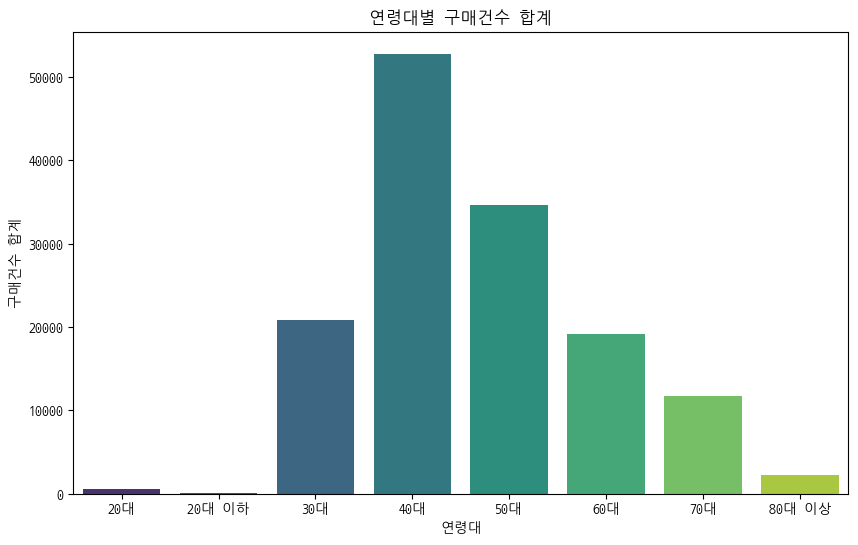

In [16]:
# 기준을 새로 만들어 연령대 별 구매건수의 합계를 계산하여 새로운 데이터프레임 생성
age_sum = new_df.groupby('age_group')['일별_회원별_구매건수'].sum().reset_index()
# 막대그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='일별_회원별_구매건수', data=age_sum, palette='viridis')
plt.title('연령대별 구매건수 합계')
plt.xlabel('연령대')
plt.ylabel('구매건수 합계')
plt.show()

In [17]:
# 변경한 데이터를 기준으로 stats.anderson을 사용한 정규 분포 검정을 통해, 바뀐 기준으로는 정규분포에 부합한다는 사실을 확인
grouped_age_sum = new_df.groupby('age_group')['일별_회원별_구매건수'].sum()
print(stats.anderson(grouped_age_sum))
result = stats.anderson(grouped_age_sum)
print('Test Statistic: %.3f' % result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print('%.1f%% 수준에서 데이터는 정규 분포를 따름 (검정 통계량 %.3f < 임계값 %.3f)' % (sl, result.statistic, cv))
    else:
        print('%.1f%% 수준에서 데이터는 정규 분포를 따르지 않음 (검정 통계량 %.3f >= 임계값 %.3f)' % (sl, result.statistic, cv))

AndersonResult(statistic=0.3770406625531315, critical_values=array([0.519, 0.591, 0.709, 0.827, 0.984]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=17754.5, scale=18557.404767754724)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Test Statistic: 0.377
15.0% 수준에서 데이터는 정규 분포를 따름 (검정 통계량 0.377 < 임계값 0.519)
10.0% 수준에서 데이터는 정규 분포를 따름 (검정 통계량 0.377 < 임계값 0.591)
5.0% 수준에서 데이터는 정규 분포를 따름 (검정 통계량 0.377 < 임계값 0.709)
2.5% 수준에서 데이터는 정규 분포를 따름 (검정 통계량 0.377 < 임계값 0.827)
1.0% 수준에서 데이터는 정규 분포를 따름 (검정 통계량 0.377 < 임계값 0.984)


### 등분산 검증 절차

In [18]:
# 등분산 검증을 위해 'age_group'의 연령대별 값을 순회
groups = [new_df[new_df['age_group'] == age]['일별_회원별_구매건수'] for age in new_df['age_group'].unique()]
# Levene 검정 수행
stats.levene(*groups)


LeveneResult(statistic=5.478049924069014, pvalue=2.6086776845391247e-06)

In [19]:
# 소수점 수치가 비슷하므로 소수점 아래 5자리에서 반올림하는 것으로 p-value 정제
round(2.6086776845391247e-06,5)

0.0

- 결과값이 0.05 미만이므로 그룹별 분산의 분포가 서로 다르다는 것을 의미하기 때문에 이분산이라고 볼 수 있으며, 이것은 각 연령 그룹의 고객들이 다른 구매 패턴을 가질 수 있는 가능성을 담고 있다.

### 이분산 범주형 3이상 집단 검사
 - kruskal test를 하는 의미 : 중위수는 데이터의 중앙값을 의미합니다. 중위수를 비교하는 이유는 각 그룹의 데이터 분포가 서로 유사한지를 판단하기 위함입니다.
 - 다시 말해, 중위수가 같다는 것은 각 그룹의 데이터가 중앙값을 기준으로 비슷한 패턴을 보인다는 것을 의미합니다. 이는 각 그룹이 동일한 중심 경향성을 가진다는 것을 나타냅니다.
 - 예를 들어, A 그룹과 B 그룹의 중위수가 같다는 것은 A 그룹과 B 그룹의 데이터가 중앙값을 기준으로 비슷한 분포를 보인다는 것을 의미합니다. 이는 두 그룹이 서로 유사한 특성을 가진다는 것을 나타낼 수 있습니다.
 - 따라서, Kruskal-Wallis H 검정을 통해 그룹 간의 중위수 비교를 통해 그룹 간의 차이를 알아볼 수 있습니다. 이를 통해 연령대별 구매 빈도가 동일한 패턴을 가지는지, 아니면 차이가 있는지를 알아볼 수 있습니다.

In [20]:
# 그룹간 분산이 동일하지 않은 집단의 대한 분석을 위해 앞서 사용한 groups 변수를 호출하여 kruskal test를 진행
stats.kruskal(*groups)

KruskalResult(statistic=40.2836938526588, pvalue=1.1107952162083155e-06)

In [21]:
# 소수점 수치가 비슷하므로 소수점 아래 5자리에서 반올림하는 것으로 p-value 정제
round(1.1107952162083155e-06,5)

0.0

- 결과값이 0.05 미만이므로 귀무가설의 기각이 성립되는 결과가 나왔다

### 분석 결과 : 회원의 연령대에 따라 구매 빈도의 분산이 동일한가?
 - 통계 결론 : P-value가 매우 미미하므로 귀무가설을 기각할 근거가 된다.
 - 사실 결론 : 그룹('age_group')의 '일별_회원별_구매건수'의 중위수가 동일하다는 귀무 가설을 기각. 즉, 'age_group'별 '일별_회원별_구매건수'의 중위수는 동일하지 않다는 추론이 가능함.
